In [1]:
#!pip3 install cython

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%load_ext Cython

In [4]:
num_steps = 50
scale = 50
damping= 0.25
initial_p = 1
stop_step = 25

In [5]:
def wave_propogation(num_steps, scale, damping, initial_P, stop_step):
    # Give types to variables we use to calculate with
    omega =  3.0 / (2.0 * np.pi)
    size_x = 2 * scale + 1

    # Setup C style arrays in python
    P = np.zeros((size_x,size_x))
    V = np.zeros((size_x,size_x,4))

    P[scale][scale] = initial_P

    for step in range(num_steps):
        if(step <= stop_step):
            P[scale][scale] = initial_P * np.sin(omega * step)
        for i in range(size_x):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_x - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]

        for i in range(size_x):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * (V[i][j][0]+V[i][j][1]+V[i][j][2]+V[i][j][3])
    return P

CPU times: user 4.38 s, sys: 4.8 ms, total: 4.39 s
Wall time: 4.39 s


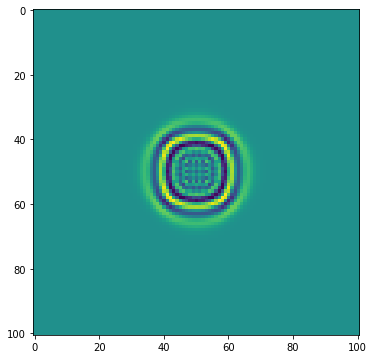

In [6]:
%time final_p = wave_propogation(num_steps, scale, damping, initial_p, stop_step)

plt.figure(figsize=(12,6))
plt.imshow(final_p)
plt.show()

In [11]:
%%cython -a

cimport cython
from libcpp cimport bool

from cython.view cimport array as cython_array
from libc.math cimport M_PI as pi
from libc.math cimport sin as sin
import numpy as np


# These turn off some python features for accessing arrays as python arrays
@cython.boundscheck(False)
@cython.wraparound(False)
# This turns off checks for divide by 0 and will seg fault instead of throw a warning
@cython.cdivision(True)
# Gave all the input variables types
def wave_propogation_cython(int num_steps, int scale,float damping,float initial_P,int stop_step):
    # Give types to variables we use to calculate with
    cdef float omega =  3.0 / (2.0 * pi)
    cdef int size_x = 2 * scale + 1

    # Give types to loop iterator variables to make loops C loops
    cdef int i = 0
    cdef int j = 0
    cdef int step = 0

    # Setup C style arrays in python
    cdef float [:,:] P = cython_array(shape=(size_x, size_x), itemsize=sizeof(float), format="f")
    P[:,:] = 0.0
    cdef float [:,:,:] V = cython_array(shape=(size_x, size_x, 4), itemsize=sizeof(float), format="f")
    V[:,:,:] = 0.0

    P[scale][scale] = initial_P

    for step in range(num_steps):
        if(step <= stop_step):
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_x):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_x - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]

        for i in range(size_x):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * (V[i][j][0]+V[i][j][1]+V[i][j][2]+V[i][j][3])
    return np.asarray(P)

CPU times: user 3.8 ms, sys: 796 µs, total: 4.59 ms
Wall time: 4.05 ms


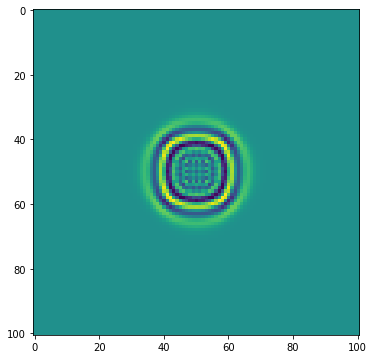

In [12]:
%time final_p = wave_propogation_cython(num_steps, scale, damping, initial_p, stop_step)
plt.figure(figsize=(12,6))
plt.imshow(final_p)
plt.show()